In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg
%matplotlib inline

In [43]:
df = pd.read_csv('/home/atrides/Desktop/R/statistics_with_Python/11_GLM2_ANCOVA/Data_Files/Elephant Football.dat', sep='\t')
df.head()  # 1:'asian elephant', 2:'african elephant'

,elephant,experience,goals
0,1,4,1
1,1,0,1
2,1,3,3
3,1,4,3
4,1,5,3


In [44]:
df.groupby(['elephant']).describe()['goals']

,count,mean,std,min,25%,50%,75%,max
elephant,,,,,,,,
1,60.0,3.533333,1.899747,0.0,2.0,4.0,5.0,8.0
2,60.0,4.616667,1.841993,0.0,3.0,5.0,6.0,8.0


In [45]:
df.groupby(['elephant']).describe()['experience']

,count,mean,std,min,25%,50%,75%,max
elephant,,,,,,,,
1,60.0,4.000000,1.657034,0.0,3.0,4.0,5.0,7.0
2,60.0,4.366667,1.756023,0.0,3.0,4.5,5.0,9.0


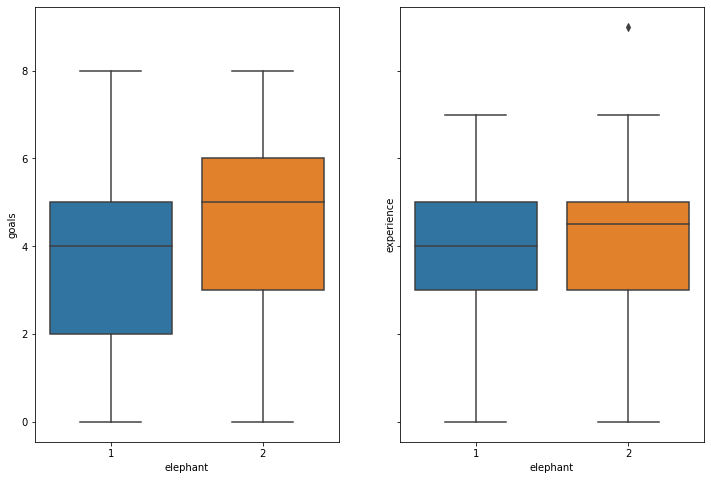

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(12,8))
_ = sns.boxplot(x='elephant', y='goals', data=df, ax=ax1)
_ = sns.boxplot(x='elephant', y='experience', data=df, ax=ax2)

In [47]:
df_1 = df[df['elephant']==1]
df_2 = df[df['elephant']==2]

In [48]:
# Levene's Test for Homogeneity of Variance (center = median)
st.levene(df_1['goals'], df_2['goals'])

LeveneResult(statistic=0.006565038388783752, pvalue=0.9355593976730989)

#### # levene test shows that homogeneity of variance is followed

In [49]:
# Checking assumption, independence of covariate and experimental manipulator
m00 = smf.ols('experience~C(elephant)', data=df).fit()
anova_table = sm.stats.anova_lm(m00)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(elephant),1.0,4.033333,4.033333,1.383795,0.241823
Residual,118.0,343.933333,2.914689,NaN,NaN


#### this assumption followed

In [50]:
m01 = smf.ols('goals~experience+C(elephant)', data=df).fit()
m01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     10.37
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           7.12e-05
Time:                        00:30:50   Log-Likelihood:                -239.56
No. Observations:                 120   AIC:                             485.1
Df Residuals:                     117   BIC:                             493.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.3071      0.453      5.087      0.000       1.409       3.205
C(elephant)[T.2]     0.9709      0.331      2.931      0.004       0.315       1.627
experience           0.3066      0.097      3.151      0.002       0.114       0.499
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.473
Skew:                          -0.007   Prob(JB):                        0.789
Kurtosis:                       2.693   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
anova_table1 = sm.stats.anova_lm(m01, typ=3)   # defaults to type 2
anova_table1

,sum_sq,df,F,PR(>F)
Intercept,84.238965,1.0,25.882524,0.000001
C(elephant),27.953402,1.0,8.588716,0.004069
experience,32.320763,1.0,9.930593,0.002065
Residual,380.795904,117.0,NaN,NaN


In [52]:
prediction = pd.DataFrame(m01.fittedvalues)
prediction.columns = ['predicted'] 
prediction['standarized_prediction']  = (prediction['predicted']-prediction['predicted'].mean())/prediction['predicted'].std()
prediction.head()

,predicted,standarized_prediction
0,3.533333,-0.719052
1,2.307127,-2.346817
2,3.226782,-1.125993
3,3.533333,-0.719052
4,3.839885,-0.312110


In [53]:
import statsmodels.stats.outliers_influence as sms

In [54]:
summary_frame = sms.OLSInfluence(m01).summary_frame()
summary_frame = pd.merge(summary_frame, prediction, how = 'inner', left_index = True, right_index = True)

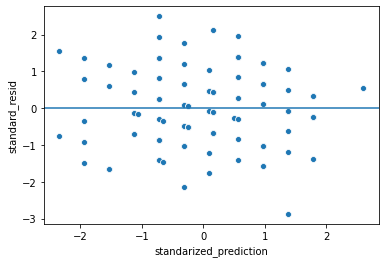

In [55]:
_ = sns.scatterplot(y = 'standard_resid', x='standarized_prediction', data = summary_frame)
_ = plt.axhline(y=0)

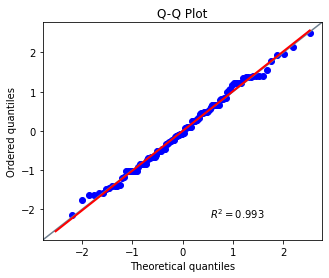

In [56]:
_ = pg.qqplot(summary_frame['standard_resid'], confidence=False)

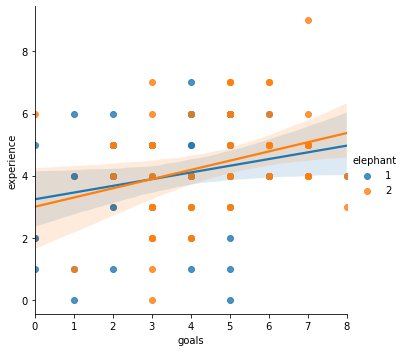

In [57]:
_ = sns.lmplot(x='goals', y='experience', hue='elephant', data=df)       # groupwise effect

#### 'hors' assumption is followed

In [58]:
# from m01 summary table

y_asian = 2.3071 + 0.3066* df['experience'].mean() + 0
y_african = 2.3071 + 0.3066* df['experience'].mean() + 1* 0.9709
print(y_asian, y_african)

3.58971 4.5606100000000005


In [59]:
hoRS_model= smf.ols('goals~C(elephant)*experience', data=df).fit()
anova_hoRS = sm.stats.anova_lm(hoRS_model, typ=3)
anova_hoRS

,sum_sq,df,F,PR(>F)
Intercept,49.796844,1.0,15.175604,0.000164
C(elephant),2.652082,1.0,0.808223,0.370509
experience,13.061728,1.0,3.980566,0.048372
C(elephant):experience,0.156435,1.0,0.047674,0.827546
Residual,380.639469,116.0,NaN,NaN


### # so our work is done, The  output  shows  that  the  interaction  between elephant and experience (the covariate) is not significant, which means that we can assume homogeneity of regression slopes.

### Robust Ancova, just for sake of the question

In [60]:
robust_anova= smf.ols('goals~experience+C(elephant)', data=df).fit()
table_robust = sm.stats.anova_lm(robust_anova, typ=2,robust='hc3')
table_robust

,sum_sq,df,F,PR(>F)
C(elephant),28.289412,1.0,8.691956,0.003860
experience,38.760501,1.0,11.909211,0.000778
Residual,380.795904,117.0,NaN,NaN


### still same conclusion, In other words in most cases the groups differ significantly in their mean number of goals scored (adjusted for number of years of football experience). Also it seems  to  that  being  an  African  elephant  increased  the  elephant’s chances of scoring more goals .